## Homework 3

In [3]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from lifelines import WeibullFitter,
                      ExponentialFitter,
                      LogNormalFitter,
                      LogLogisticFitter

In [17]:
from lifelines import WeibullAFTFitter,
                      LogNormalAFTFitter,
                      LogLogisticAFTFitter, PiecewiseExponentialRegressionFitter

In [4]:
telco = pd.read_csv('telco.csv') 
telco.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


We see that we have several columns for which we have to do transformations. We will convert make region, marital, ed, gender, retire, voice, innternet, forward, cutscat to categorical variables using encodings.

In [5]:
cols = ['region','marital','ed','gender', 'retire','voice','internet','forward','churn', 'custcat']
 
encoded = pd.get_dummies(telco,
               columns=cols,
               prefix=cols,
               drop_first=False)
 
encoded.head()

,ID,tenure,age,address,income,region_Zone 1,region_Zone 2,region_Zone 3,marital_Married,marital_Unmarried,...,internet_No,internet_Yes,forward_No,forward_Yes,churn_No,churn_Yes,custcat_Basic service,custcat_E-service,custcat_Plus service,custcat_Total service
0,1,13,44,9,64,0,1,0,1,0,...,1,0,0,1,0,1,1,0,0,0
1,2,11,33,7,136,0,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1
2,3,68,52,24,116,0,0,1,1,0,...,1,0,1,0,1,0,0,0,1,0
3,4,33,33,12,33,0,1,0,0,1,...,1,0,1,0,0,1,1,0,0,0
4,5,23,30,9,30,0,1,0,1,0,...,1,0,0,1,1,0,0,0,1,0


In [6]:
telco['region'].unique()

array(['Zone 2', 'Zone 3', 'Zone 1'], dtype=object)

You can see that we have one column is redundant and leads to multicollinearity in our model, so we keep the columns that we need for further analysis.

In [9]:
encoded.columns

Index(['ID', 'tenure', 'age', 'address', 'income', 'region_Zone 1',
       'region_Zone 2', 'region_Zone 3', 'marital_Married',
       'marital_Unmarried', 'ed_College degree',
       'ed_Did not complete high school', 'ed_High school degree',
       'ed_Post-undergraduate degree', 'ed_Some college', 'gender_Female',
       'gender_Male', 'retire_No', 'retire_Yes', 'voice_No', 'voice_Yes',
       'internet_No', 'internet_Yes', 'forward_No', 'forward_Yes', 'churn_No',
       'churn_Yes', 'custcat_Basic service', 'custcat_E-service',
       'custcat_Plus service', 'custcat_Total service'],
      dtype='object')

In [10]:
survival = encoded[["age", "income", "churn_Yes","tenure","marital_Married",
                    "forward_Yes","internet_Yes", "custcat_E-service",
                          "custcat_Plus service","custcat_Total service",
                    "region_Zone 3","region_Zone 2"]]

In [11]:
survival.head()

,age,income,churn_Yes,tenure,marital_Married,forward_Yes,internet_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,region_Zone 3,region_Zone 2
0,44,64,1,13,1,1,0,0,0,0,0,1
1,33,136,1,11,1,1,0,0,0,1,1,0
2,52,116,0,68,1,0,0,0,1,0,1,0
3,33,33,1,33,0,0,0,0,0,0,0,1
4,30,30,0,23,1,1,0,0,1,0,0,1


In [13]:
survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    1000 non-null   int64
 1   income                 1000 non-null   int64
 2   churn_Yes              1000 non-null   uint8
 3   tenure                 1000 non-null   int64
 4   marital_Married        1000 non-null   uint8
 5   forward_Yes            1000 non-null   uint8
 6   internet_Yes           1000 non-null   uint8
 7   custcat_E-service      1000 non-null   uint8
 8   custcat_Plus service   1000 non-null   uint8
 9   custcat_Total service  1000 non-null   uint8
 10  region_Zone 3          1000 non-null   uint8
 11  region_Zone 2          1000 non-null   uint8
dtypes: int64(3), uint8(9)
memory usage: 32.4 KB


##### Accelerated Failure Time Model

In [16]:
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

In [24]:
we_aft = WeibullAFTFitter()
we_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
we_aft_pd = we_aft.predict_survival_function(survival).transpose()
avg_we = we_aft_pd.mean().to_list()
we_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.996000,0.991093,0.985791,0.980227,0.974469,0.968560,0.962529,0.956398,0.950185,0.943903,...,0.614516,0.609031,0.603582,0.598169,0.592791,0.587449,0.582143,0.576873,0.571639,0.566440
1,0.997348,0.994090,0.990563,0.986855,0.983010,0.979057,0.975014,0.970895,0.966711,0.962471,...,0.724254,0.719965,0.715691,0.711431,0.707187,0.702958,0.698745,0.694547,0.690365,0.686199
2,0.999206,0.998228,0.997167,0.996048,0.994885,0.993686,0.992457,0.991200,0.989920,0.988619,...,0.907974,0.906362,0.904748,0.903133,0.901518,0.899901,0.898284,0.896666,0.895047,0.893427
3,0.989411,0.976517,0.962702,0.948336,0.933611,0.918649,0.903534,0.888329,0.873083,0.857834,...,0.274357,0.267901,0.261582,0.255396,0.249343,0.243419,0.237623,0.231952,0.226403,0.220976
4,0.995885,0.990837,0.985383,0.979660,0.973740,0.967664,0.961465,0.955165,0.948781,0.942327,...,0.605916,0.600353,0.594826,0.589338,0.583887,0.578474,0.573098,0.567760,0.562460,0.557198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.993926,0.986493,0.978482,0.970100,0.961451,0.952603,0.943601,0.934481,0.925269,0.915986,...,0.477053,0.470596,0.464211,0.457897,0.451655,0.445482,0.439381,0.433348,0.427386,0.421492
996,0.990257,0.978383,0.965646,0.952386,0.938778,0.924933,0.910928,0.896820,0.882655,0.868467,...,0.304396,0.297803,0.291336,0.284994,0.278776,0.272679,0.266702,0.260842,0.255099,0.249469
997,0.998743,0.997196,0.995519,0.993752,0.991916,0.990024,0.988086,0.986106,0.984091,0.982044,...,0.858289,0.855877,0.853467,0.851057,0.848648,0.846241,0.843834,0.841429,0.839026,0.836624
998,0.998455,0.996554,0.994494,0.992324,0.990071,0.987750,0.985373,0.982947,0.980478,0.977972,...,0.828726,0.825864,0.823005,0.820150,0.817297,0.814447,0.811601,0.808758,0.805919,0.803083


In [37]:
logn_aft = LogNormalAFTFitter()
logn_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
logn_aft_pd = logn_aft.predict_survival_function(survival).transpose()
avg_logn = logn_aft_pd.mean().to_list()
logn_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.999460,0.997124,0.993148,0.987914,0.981741,0.974867,0.967474,0.959698,0.951643,0.943392,...,0.593706,0.589230,0.584812,0.580451,0.576146,0.571896,0.567700,0.563556,0.559465,0.555424
1,0.999831,0.998956,0.997287,0.994916,0.991954,0.988499,0.984637,0.980438,0.975962,0.971257,...,0.709794,0.705835,0.701914,0.698029,0.694181,0.690369,0.686592,0.682851,0.679144,0.675471
2,0.999997,0.999967,0.999888,0.999750,0.999545,0.999273,0.998933,0.998527,0.998056,0.997523,...,0.928289,0.926699,0.925108,0.923516,0.921922,0.920328,0.918733,0.917137,0.915541,0.913945
3,0.995401,0.982022,0.964127,0.944107,0.923200,0.902084,0.881143,0.860598,0.840574,0.821141,...,0.334657,0.330470,0.326370,0.322352,0.318415,0.314556,0.310774,0.307065,0.303428,0.299860
4,0.999573,0.997654,0.994310,0.989838,0.984498,0.978494,0.971985,0.965091,0.957908,0.950509,...,0.619052,0.614654,0.610309,0.606017,0.601777,0.597587,0.593448,0.589359,0.585318,0.581324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998268,0.992153,0.982966,0.971853,0.959548,0.946525,0.933097,0.919475,0.905805,0.892191,...,0.456779,0.452211,0.447721,0.443306,0.438964,0.434693,0.430493,0.426360,0.422294,0.418293
996,0.995887,0.983637,0.967022,0.948261,0.928531,0.908491,0.888525,0.868858,0.849624,0.830900,...,0.348606,0.344353,0.340186,0.336101,0.332096,0.328170,0.324319,0.320542,0.316836,0.313200
997,0.999990,0.999913,0.999726,0.999414,0.998973,0.998405,0.997716,0.996912,0.996000,0.994988,...,0.890313,0.888135,0.885961,0.883791,0.881625,0.879464,0.877306,0.875154,0.873006,0.870864
998,0.999952,0.999657,0.999026,0.998060,0.996779,0.995215,0.993397,0.991355,0.989113,0.986695,...,0.807953,0.804790,0.801644,0.798518,0.795409,0.792319,0.789247,0.786193,0.783158,0.780140


In [26]:
loglog_aft = LogLogisticAFTFitter()
loglog_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
loglog_aft_pd = loglog_aft.predict_survival_function(survival).transpose()
avg_loglog = loglog_aft_pd.mean().to_list() #computing the average survival time for each month
loglog_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.997595,0.993835,0.989334,0.984293,0.978826,0.973013,0.966911,0.960566,0.954013,0.947285,...,0.593786,0.588598,0.583470,0.578403,0.573397,0.568449,0.563561,0.558730,0.553958,0.549242
1,0.998665,0.996574,0.994060,0.991233,0.988153,0.984860,0.981386,0.977752,0.973978,0.970079,...,0.725075,0.720775,0.716501,0.712255,0.708035,0.703843,0.699678,0.695540,0.691430,0.687347
2,0.999719,0.999278,0.998745,0.998144,0.997485,0.996778,0.996028,0.995238,0.994414,0.993556,...,0.926158,0.924677,0.923191,0.921702,0.920210,0.918715,0.917216,0.915714,0.914210,0.912703
3,0.992053,0.979809,0.965423,0.949655,0.932956,0.915635,0.897920,0.879985,0.861967,0.843974,...,0.305561,0.301025,0.296597,0.292273,0.288051,0.283927,0.279898,0.275962,0.272115,0.268355
4,0.997769,0.994281,0.990102,0.985419,0.980336,0.974927,0.969245,0.963329,0.957216,0.950932,...,0.611869,0.606758,0.601704,0.596706,0.591763,0.586875,0.582042,0.577262,0.572537,0.567864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.995714,0.989049,0.981119,0.972304,0.962823,0.952828,0.942432,0.931723,0.920773,0.909642,...,0.450219,0.444911,0.439698,0.434577,0.429547,0.424605,0.419750,0.414981,0.410294,0.405689
996,0.992331,0.980507,0.966601,0.951343,0.935166,0.918366,0.901163,0.883725,0.866183,0.848642,...,0.313230,0.308631,0.304139,0.299753,0.295467,0.291281,0.287189,0.283191,0.279282,0.275461
997,0.999360,0.998355,0.997144,0.995778,0.994285,0.992685,0.990990,0.989210,0.987355,0.985430,...,0.846193,0.843379,0.840566,0.837757,0.834952,0.832150,0.829352,0.826558,0.823768,0.820983
998,0.999207,0.997963,0.996465,0.994776,0.992931,0.990955,0.988864,0.986670,0.984384,0.982016,...,0.816237,0.812995,0.809760,0.806533,0.803314,0.800104,0.796902,0.793709,0.790525,0.787350


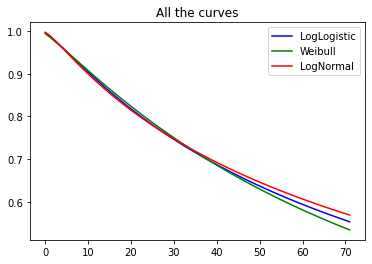

In [33]:
plt.plot(avg_loglog, color = 'blue', label = 'LogLogistic')
plt.plot(avg_we, color = "green", label = "Weibull")
plt.plot(avg_logn, color = "red", label = "LogNormal")
plt.legend()
plt.title("All the curves")
plt.show()

In [31]:
for model in [wb, ex, log, loglogis]:
    model.fit(durations = survival["tenure"], event_observed = survival["churn_Yes"])
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 3216.8611706815464
The AIC value for ExponentialFitter is 3215.9608134637247
The AIC value for LogNormalFitter is 3209.0351474316735
The AIC value for LogLogisticFitter is 3214.4154757933375


The AIC values are used to compare the goodness of fit of the models. The lower the AIC value, the better the model is at fitting the data.

The WeibullFitter model has an AIC value of 3216.8611706815464.

The ExponentialFitter model has an AIC value of 3215.9608134637247. This suggests that the exponential distribution may be a slightly better fit to the data than the Weibull distribution.

The LogNormalFitter model has the lowest AIC value among the models, with a value of 3209.0351474316735. This suggests that the log-normal distribution may be the best fit to the data among the models.

The LogLogisticFitter model has an AIC value of 3214.4154757933375. 

In [38]:
logn_aft.print_summary()  

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1477.11
         time fit was run = 2023-04-30 17:06:53 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    age                     0.05       1.06       0.01             0.04             0.07                 1.04                 1.07
       custcat_E-service       1.06       2.89       0.17             0.72             1.40                 2.06                 4.05
       custcat_Plus service    0.89       2.45       0.22             0.47             1.32                 1.59                 3.75
       custcat_Total service   0.84       2.31       0.22             0.40             1.28                 1.49                 3.58
       forward_Yes            -0.17       0.84       0.18            -0.53             0.19                 0.59                 1.21
       income                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes           -0.97       0.38       0.14            -1.24            -0.69                 0.29                 0.50
       marital_Married         0.44       1.56       0.12             0.21             0.67                 1.24                 1.96
       region_Zone 2          -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
       region_Zone 3           0.10       1.11       0.14            -0.18             0.39                 0.84                 1.47
       Intercept               1.73       5.62       0.25             1.23             2.22                 3.41                 9.25
sigma_ Intercept               0.31       1.37       0.05             0.22             0.40                 1.25                 1.50

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    age                       0.00  9.58 <0.005      69.77
       custcat_E-service         0.00  6.15 <0.005      30.28
       custcat_Plus service      0.00  4.09 <0.005      14.51
       custcat_Total service     0.00  3.76 <0.005      12.53
       forward_Yes               0.00 -0.94   0.35       1.52
       income                    0.00  1.28   0.20       2.31
       internet_Yes              0.00 -6.80 <0.005      36.52
       marital_Married           0.00  3.76 <0.005      12.53
       region_Zone 2             0.00 -0.07   0.95       0.08
       region_Zone 3             0.00  0.72   0.47       1.09
       Intercept                 0.00  6.79 <0.005      36.38
sigma_ Intercept                 0.00  6.75 <0.005      35.99
---
Concordance = 0.77
AIC = 2978.22
log-likelihood ratio test = 250.82 on 10 df
-log2(p) of ll-ratio test = 157.58

##### Interpretation

The duration column is 'tenure' and the event column is 'churn_Yes'.

For every one unit increase in the independent variable, we get (exp(coef) - 1 )* 100% percent increase in dependent variable, holding all other variables constant.

For example, for the 'age' variable, an exp(coef) of 1.06 means that for each one-year increase in age, the likelihood of the outcome occurring (churn) increases by (1.06 - 1)*100%, holding other variables constant.

Using these results we can determine which features are significant to keep them for further process.
If a predictor variable has a high p-value, it is often considered non-significant and can be removed from the model. 
We can see that forward_Yes has a p-value of 0.35, income has a p-value of 0.2, region_Zone2 has a p-value of 0.95 and region_Zone 3 has a p-value of 0.47, thus we remove them and keep only the significant features. 

##### The final model

In [39]:
survival= survival[['age','churn_Yes','tenure','marital_Married','internet_Yes', 'custcat_E-service',\
                          'custcat_Plus service','custcat_Total service']]

In [40]:
logn_aft = LogNormalAFTFitter()
logn_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
logn_aft_pd = logn_aft.predict_survival_function(survival).transpose()
logn_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.999668,0.998125,0.995376,0.991641,0.987129,0.982007,0.976407,0.970434,0.964171,0.957685,...,0.648676,0.644406,0.640184,0.636009,0.631882,0.627801,0.623765,0.619774,0.615827,0.611924
1,0.999742,0.998493,0.996214,0.993066,0.989216,0.984802,0.979937,0.974710,0.969196,0.963453,...,0.673488,0.669335,0.665225,0.661159,0.657136,0.653154,0.649215,0.645316,0.641457,0.637639
2,0.999992,0.999929,0.999775,0.999516,0.999146,0.998666,0.998081,0.997396,0.996615,0.995744,...,0.901193,0.899180,0.897169,0.895160,0.893153,0.891150,0.889149,0.887152,0.885158,0.883167
3,0.995676,0.982997,0.965940,0.946774,0.926688,0.906342,0.886111,0.866219,0.846792,0.827903,...,0.345768,0.341541,0.337400,0.333340,0.329361,0.325460,0.321634,0.317881,0.314200,0.310588
4,0.999644,0.998007,0.995111,0.991194,0.986479,0.981141,0.975319,0.969122,0.962635,0.955926,...,0.641538,0.637237,0.632986,0.628784,0.624631,0.620524,0.616464,0.612450,0.608482,0.604557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998000,0.991166,0.981085,0.969038,0.955815,0.941915,0.927662,0.913273,0.898892,0.884620,...,0.442640,0.438108,0.433655,0.429277,0.424974,0.420743,0.416583,0.412492,0.408468,0.404510
996,0.996182,0.984694,0.969000,0.951182,0.932366,0.913186,0.894019,0.875088,0.856529,0.838422,...,0.361411,0.357116,0.352905,0.348776,0.344727,0.340755,0.336858,0.333034,0.329282,0.325598
997,0.999811,0.998851,0.997048,0.994507,0.991353,0.987692,0.983616,0.979201,0.974507,0.969585,...,0.702654,0.698664,0.694712,0.690798,0.686921,0.683082,0.679280,0.675513,0.671783,0.668087
998,0.999945,0.999615,0.998921,0.997866,0.996479,0.994794,0.992845,0.990663,0.988276,0.985709,...,0.801368,0.798150,0.794951,0.791771,0.788611,0.785471,0.782350,0.779249,0.776167,0.773104


In [42]:
logn_aft.predict_hazard(survival).transpose()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.000887,0.002185,0.003295,0.004190,0.004905,0.005479,0.005942,0.006317,0.006622,0.006871,...,0.006621,0.006589,0.006558,0.006526,0.006495,0.006464,0.006434,0.006404,0.006374,0.006344
1,0.000702,0.001790,0.002753,0.003549,0.004198,0.004728,0.005163,0.005521,0.005817,0.006062,...,0.006200,0.006172,0.006145,0.006118,0.006090,0.006064,0.006037,0.006010,0.005984,0.005958
2,0.000027,0.000104,0.000205,0.000315,0.000425,0.000534,0.000637,0.000736,0.000830,0.000917,...,0.002235,0.002238,0.002240,0.002243,0.002245,0.002247,0.002248,0.002250,0.002251,0.002252
3,0.009307,0.015646,0.019022,0.020879,0.021903,0.022437,0.022671,0.022714,0.022634,0.022473,...,0.012349,0.012250,0.012152,0.012056,0.011963,0.011871,0.011780,0.011691,0.011604,0.011518
4,0.000946,0.002309,0.003464,0.004388,0.005122,0.005708,0.006178,0.006557,0.006864,0.007113,...,0.006743,0.006709,0.006677,0.006644,0.006612,0.006580,0.006548,0.006517,0.006486,0.006455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004635,0.008800,0.011445,0.013145,0.014257,0.014990,0.015469,0.015773,0.015953,0.016044,...,0.010328,0.010254,0.010182,0.010110,0.010040,0.009971,0.009903,0.009836,0.009770,0.009705
996,0.008322,0.014274,0.017545,0.019401,0.020461,0.021048,0.021339,0.021440,0.021415,0.021306,...,0.012003,0.011908,0.011815,0.011723,0.011634,0.011545,0.011459,0.011374,0.011290,0.011208
997,0.000525,0.001396,0.002199,0.002883,0.003454,0.003930,0.004328,0.004661,0.004941,0.005178,...,0.005707,0.005684,0.005661,0.005638,0.005616,0.005594,0.005571,0.005549,0.005527,0.005505
998,0.000164,0.000509,0.000879,0.001229,0.001547,0.001832,0.002085,0.002310,0.002510,0.002688,...,0.004029,0.004020,0.004012,0.004003,0.003995,0.003986,0.003977,0.003968,0.003958,0.003949


In [43]:
logn_aft.print_summary() 

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1478.86
         time fit was run = 2023-04-30 17:43:41 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    age                     0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
       custcat_E-service       1.06       2.89       0.17             0.72             1.40                 2.06                 4.06
       custcat_Plus service    0.78       2.18       0.17             0.45             1.11                 1.57                 3.04
       custcat_Total service   0.73       2.07       0.17             0.39             1.06                 1.48                 2.89
       internet_Yes           -0.95       0.39       0.14            -1.23            -0.68                 0.29                 0.51
       marital_Married         0.43       1.54       0.12             0.20             0.66                 1.23                 1.94
       Intercept               1.70       5.45       0.23             1.24             2.15                 3.46                 8.59
sigma_ Intercept               0.32       1.37       0.05             0.22             0.41                 1.25                 1.50

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    age                       0.00 10.84 <0.005      88.54
       custcat_E-service         0.00  6.16 <0.005      30.38
       custcat_Plus service      0.00  4.62 <0.005      17.97
       custcat_Total service     0.00  4.28 <0.005      15.72
       internet_Yes              0.00 -6.75 <0.005      35.96
       marital_Married           0.00  3.70 <0.005      12.15
       Intercept                 0.00  7.30 <0.005      41.67
sigma_ Intercept                 0.00  6.82 <0.005      36.64
---
Concordance = 0.77
AIC = 2973.71
log-likelihood ratio test = 247.32 on 6 df
-log2(p) of ll-ratio test = 165.48

In [44]:
MM = 1300
sequence = range(1,len(logn_aft_pd.columns)+1)
r = 0.1

for num in sequence:
    logn_aft_pd.loc[:,num] = logn_aft_pd.loc[:,num]/((1+r/12)**(sequence[num-1]-1))

In [45]:
logn_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.999668,0.989876,0.978991,0.967258,0.954899,0.942093,0.928979,0.915666,0.902238,0.888762,...,0.387768,0.382032,0.376392,0.370847,0.365396,0.360036,0.354765,0.349582,0.344485,0.339473
1,0.999742,0.990241,0.979815,0.968648,0.956918,0.944775,0.932338,0.919701,0.906940,0.894115,...,0.402600,0.396811,0.391115,0.385512,0.379999,0.374576,0.369239,0.363989,0.358822,0.353738
2,0.999992,0.991665,0.983318,0.974939,0.966523,0.958076,0.949601,0.941106,0.932598,0.924082,...,0.538719,0.533073,0.527485,0.521954,0.516480,0.511063,0.505702,0.500396,0.495145,0.489948
3,0.995676,0.974873,0.950040,0.923493,0.896432,0.869503,0.843070,0.817332,0.792399,0.768320,...,0.206695,0.202481,0.198372,0.194366,0.190458,0.186647,0.182928,0.179300,0.175759,0.172303
4,0.999644,0.989759,0.978730,0.966822,0.954270,0.941262,0.927944,0.914428,0.900800,0.887130,...,0.383501,0.377782,0.372161,0.366635,0.361203,0.355863,0.350613,0.345451,0.340376,0.335386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998000,0.982974,0.964936,0.945210,0.924607,0.903631,0.882602,0.861731,0.841152,0.820956,...,0.264603,0.259730,0.254965,0.250305,0.245748,0.241291,0.236931,0.232665,0.228491,0.224407
996,0.996182,0.976556,0.953049,0.927794,0.901924,0.876070,0.850593,0.825701,0.801510,0.778082,...,0.216046,0.211714,0.207489,0.203366,0.199344,0.195419,0.191587,0.187847,0.184195,0.180630
997,0.999811,0.990596,0.980636,0.970053,0.958985,0.947547,0.935839,0.923938,0.911910,0.899806,...,0.420035,0.414198,0.408452,0.402794,0.397223,0.391739,0.386339,0.381021,0.375786,0.370630
998,0.999945,0.991354,0.982478,0.973329,0.963944,0.954361,0.944619,0.934754,0.924795,0.914769,...,0.479045,0.473178,0.467387,0.461670,0.456027,0.450457,0.444960,0.439533,0.434176,0.428889


In [46]:
logn_aft_pd["CLV"] = MM * logn_aft_pd.sum(axis = 1)
logn_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,CLV
0,0.999668,0.989876,0.978991,0.967258,0.954899,0.942093,0.928979,0.915666,0.902238,0.888762,...,0.382032,0.376392,0.370847,0.365396,0.360036,0.354765,0.349582,0.344485,0.339473,57650.551031
1,0.999742,0.990241,0.979815,0.968648,0.956918,0.944775,0.932338,0.919701,0.906940,0.894115,...,0.396811,0.391115,0.385512,0.379999,0.374576,0.369239,0.363989,0.358822,0.353738,58758.553239
2,0.999992,0.991665,0.983318,0.974939,0.966523,0.958076,0.949601,0.941106,0.932598,0.924082,...,0.533073,0.527485,0.521954,0.516480,0.511063,0.505702,0.500396,0.495145,0.489948,67697.591050
3,0.995676,0.974873,0.950040,0.923493,0.896432,0.869503,0.843070,0.817332,0.792399,0.768320,...,0.202481,0.198372,0.194366,0.190458,0.186647,0.182928,0.179300,0.175759,0.172303,41496.758733
4,0.999644,0.989759,0.978730,0.966822,0.954270,0.941262,0.927944,0.914428,0.900800,0.887130,...,0.377782,0.372161,0.366635,0.361203,0.355863,0.350613,0.345451,0.340376,0.335386,57326.705925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998000,0.982974,0.964936,0.945210,0.924607,0.903631,0.882602,0.861731,0.841152,0.820956,...,0.259730,0.254965,0.250305,0.245748,0.241291,0.236931,0.232665,0.228491,0.224407,47278.819061
996,0.996182,0.976556,0.953049,0.927794,0.901924,0.876070,0.850593,0.825701,0.801510,0.778082,...,0.211714,0.207489,0.203366,0.199344,0.195419,0.191587,0.187847,0.184195,0.180630,42480.538078
997,0.999811,0.990596,0.980636,0.970053,0.958985,0.947547,0.935839,0.923938,0.911910,0.899806,...,0.414198,0.408452,0.402794,0.397223,0.391739,0.386339,0.381021,0.375786,0.370630,60026.602495
998,0.999945,0.991354,0.982478,0.973329,0.963944,0.954361,0.944619,0.934754,0.924795,0.914769,...,0.473178,0.467387,0.461670,0.456027,0.450457,0.444960,0.439533,0.434176,0.428889,64051.170407


In [47]:
logn_aft_pd["CLV"] = MM * logn_aft_pd.sum(axis = 1)
logn_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,CLV
0,0.999668,0.989876,0.978991,0.967258,0.954899,0.942093,0.928979,0.915666,0.902238,0.888762,...,0.382032,0.376392,0.370847,0.365396,0.360036,0.354765,0.349582,0.344485,0.339473,7.500337e+07
1,0.999742,0.990241,0.979815,0.968648,0.956918,0.944775,0.932338,0.919701,0.906940,0.894115,...,0.396811,0.391115,0.385512,0.379999,0.374576,0.369239,0.363989,0.358822,0.353738,7.644488e+07
2,0.999992,0.991665,0.983318,0.974939,0.966523,0.958076,0.949601,0.941106,0.932598,0.924082,...,0.533073,0.527485,0.521954,0.516480,0.511063,0.505702,0.500396,0.495145,0.489948,8.807457e+07
3,0.995676,0.974873,0.950040,0.923493,0.896432,0.869503,0.843070,0.817332,0.792399,0.768320,...,0.202481,0.198372,0.194366,0.190458,0.186647,0.182928,0.179300,0.175759,0.172303,5.398728e+07
4,0.999644,0.989759,0.978730,0.966822,0.954270,0.941262,0.927944,0.914428,0.900800,0.887130,...,0.377782,0.372161,0.366635,0.361203,0.355863,0.350613,0.345451,0.340376,0.335386,7.458204e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.998000,0.982974,0.964936,0.945210,0.924607,0.903631,0.882602,0.861731,0.841152,0.820956,...,0.259730,0.254965,0.250305,0.245748,0.241291,0.236931,0.232665,0.228491,0.224407,6.150974e+07
996,0.996182,0.976556,0.953049,0.927794,0.901924,0.876070,0.850593,0.825701,0.801510,0.778082,...,0.211714,0.207489,0.203366,0.199344,0.195419,0.191587,0.187847,0.184195,0.180630,5.526718e+07
997,0.999811,0.990596,0.980636,0.970053,0.958985,0.947547,0.935839,0.923938,0.911910,0.899806,...,0.414198,0.408452,0.402794,0.397223,0.391739,0.386339,0.381021,0.375786,0.370630,7.809461e+07
998,0.999945,0.991354,0.982478,0.973329,0.963944,0.954361,0.944619,0.934754,0.924795,0.914769,...,0.473178,0.467387,0.461670,0.456027,0.450457,0.444960,0.439533,0.434176,0.428889,8.333057e+07


In [48]:
telco["CLV"] = logn_aft_pd.CLV

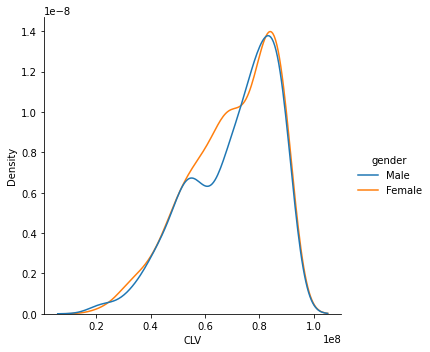

In [51]:
import seaborn as sns
sns.displot(data=telco, kind='kde', x='CLV', hue='gender')

In [62]:
telco.groupby("gender")[["CLV"]].mean()

,CLV
gender,
Female,6.985903e+07
Male,7.025169e+07


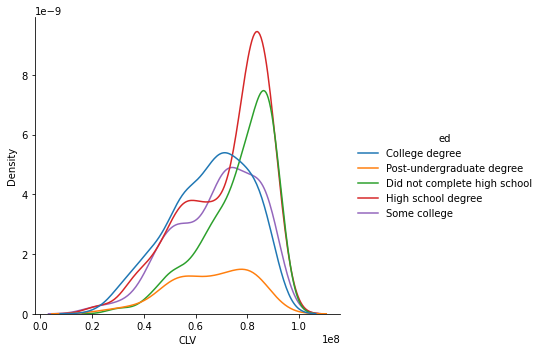

In [52]:
sns.displot(data=telco, kind='kde', x='CLV', hue='ed')

In [72]:
telco.groupby("ed")[["CLV"]].mean()

,CLV
ed,
College degree,6.548143e+07
Did not complete high school,7.626327e+07
High school degree,7.160515e+07
Post-undergraduate degree,6.572961e+07
Some college,6.832293e+07


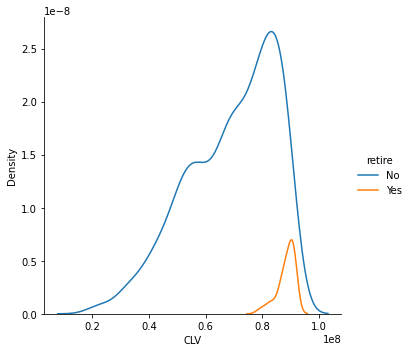

In [53]:
sns.displot(data=telco, kind='kde', x='CLV', hue='retire')

In [71]:
telco.groupby("retire")[["CLV"]].mean()

,CLV
retire,
No,6.914301e+07
Yes,8.841269e+07


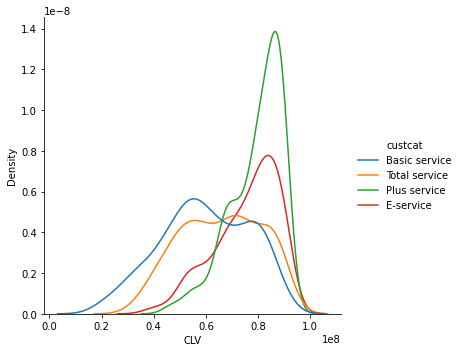

In [54]:
sns.displot(data=telco, kind='kde', x='CLV', hue='custcat')

In [70]:
telco.groupby("custcat")[["CLV"]].mean()

,CLV
custcat,
Basic service,5.957582e+07
E-service,7.553062e+07
Plus service,7.933264e+07
Total service,6.575806e+07


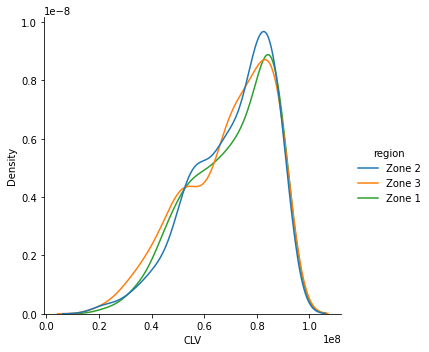

In [56]:
sns.displot(data=telco, kind='kde', x='CLV', hue='region')

In [69]:
telco.groupby("region")[["CLV"]].mean()

,CLV
region,
Zone 1,7.033867e+07
Zone 2,7.061963e+07
Zone 3,6.922290e+07


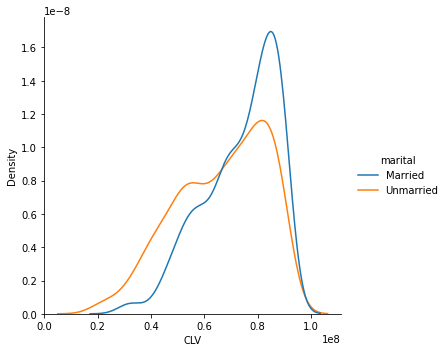

In [57]:
sns.displot(data=telco, kind='kde', x='CLV', hue='marital')

In [68]:
telco.groupby("marital")[["CLV"]].mean()

,CLV
marital,
Married,7.379958e+07
Unmarried,6.637206e+07


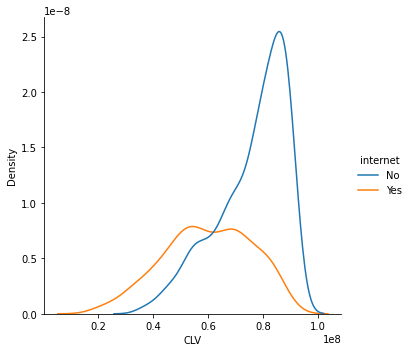

In [58]:
sns.displot(data=telco, kind='kde', x='CLV', hue='internet')

In [67]:
telco.groupby("internet")[["CLV"]].mean()

,CLV
internet,
No,7.599161e+07
Yes,5.984236e+07


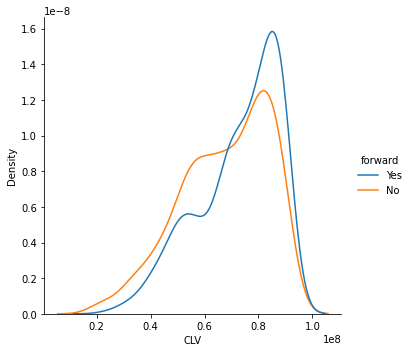

In [59]:
sns.displot(data=telco, kind='kde', x='CLV', hue='forward')

In [66]:
telco.groupby("forward")[["CLV"]].mean()

,CLV
forward,
No,6.755685e+07
Yes,7.261129e+07


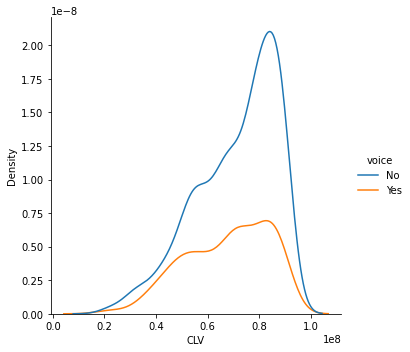

In [60]:
sns.displot(data=telco, kind='kde', x='CLV', hue='voice')

In [65]:
telco.groupby("voice")[["CLV"]].mean()

,CLV
voice,
No,7.112395e+07
Yes,6.758691e+07


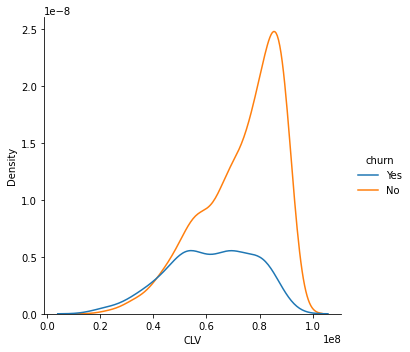

In [61]:
sns.displot(data=telco, kind='kde', x='CLV', hue='churn')

##### The analysis shows that several factors affect churn risk in this dataset. The log-normal accelerated failure time model suggests that customer age, customer category, internet availability, marital status, and region of residence are all significant predictors of churn risk. Specifically, younger customers, customers with e-service or total service, customers without internet availability, unmarried customers, and customers in Zone 2 have a higher churn risk. On the other hand, the variables region_Zone 3, 2, income, and forward_Yes have no significant impact on churn risk.

##### The most profitable customer segments, based on their average CLV, are retirees, followed by those in the Plus Service customer category, and then those who have not completed high school. Therefore, these segments are considered valuable as they have the potential to generate higher profits.